# Training a model to predict success of Kickstarter projects

The goal here is provide the extracted features from a single campaign section into a machine learning model in order to report the likelihood that a project will be funded. 

## Table of contents
1. [Loading the data](#cell1)
2. [Constructing the design matrix](#cell2)
3. [Cleaning the features](#cell3)
4. [Standardizing the features](#cell4)
5. [Encoding the target variable](#cell5)
6. [Training a model with the hold-out method](#cell6)
7. [Diagnosing the model with learning curves](#cell7)
8. [Using nested cross-validation to optimize hyperparameters](#cell8)
9. [Top predictors of funded projects](#cell9)
10. [Testing Kickstarter pages](#cell10)

<a id="cell1"></a>
## 1. Loading the data

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score
)

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

The training set for both campaign sections are stored in PostgreSQL databases. Let's begin by loading the credentials to connect to the databases.

In [2]:
# Set database credentials
db_name1 = 'section1'
db_name2 = 'section2'
usernm = 'redwan'
host = 'localhost'
port = '5432'

We can now connect to the databases, query all the data for both campaign sections, and store them locally.

In [3]:
# Prepare a connection to database for section 1
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Prepare a connection for section 2
con2 = psycopg2.connect(
    database=db_name2, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from both campaign sections
sql_query1 = 'SELECT * FROM section1;'
sql_query2 = 'SELECT * FROM section2;'
section1_df_full = pd.read_sql_query(sql_query1, con1)
section2_df_full = pd.read_sql_query(sql_query2, con2)

<a id="cell2"></a>
## 2. Constructing the design matrix

The first step is to select the features that we'll utilize for prediction. For now, let's use the computed features listed below for only the *About this project* section of the campaigns.

In [4]:
# A list of features to use in the machine learning model
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
             'num_exclms', 'percent_exclms', 'num_apple_words',
             'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
             'avg_sents_per_paragraph', 'avg_words_per_paragraph',
             'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
             'num_hyperlinks', 'num_bolded', 'percent_bolded']

# Select features
X = section1_df_full[features]

# Display the first five rows of the design matrix
X.head()

,num_sents,num_words,num_all_caps,percent_all_caps,num_exclms,percent_exclms,num_apple_words,percent_apple_words,avg_words_per_sent,num_paragraphs,avg_sents_per_paragraph,avg_words_per_paragraph,num_images,num_videos,num_youtubes,num_gifs,num_hyperlinks,num_bolded,percent_bolded
0,15.0,223.0,0.0,0.000000,3.0,0.002317,0.0,0.000000,14.866667,9.0,1.888889,24.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,15.0,383.0,0.0,0.000000,4.0,0.003089,0.0,0.000000,25.533333,5.0,3.000000,76.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,15.0,259.0,17.0,0.013127,0.0,0.000000,1.0,0.000772,17.266667,17.0,0.823529,11.470588,15.0,0.0,0.0,0.0,8.0,0.0,0.000000
3,18.0,431.0,0.0,0.000000,3.0,0.002317,1.0,0.000772,23.944444,3.0,6.000000,143.666667,0.0,0.0,0.0,0.0,2.0,0.0,0.000000
4,23.0,283.0,2.0,0.001544,15.0,0.011583,0.0,0.000000,12.304348,5.0,4.600000,56.600000,1.0,0.0,0.0,0.0,0.0,12.0,0.009266


<a id="cell3"></a>
## 3. Cleaning the features

Many of the projects contain features with missing values. We need to decide how to deal with these values since machine learning models in Scikit-learn cannot interpret them.

One strategy is to first remove all projects that have no data. These projects are most likely those that failed to complete an *About this project* section and can safely be excluded.

In [5]:
# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

For the remaining projects with missing values, we can fill them with zeros. This makes sense since missing values arise as a result of missing data or if the number of words in the section is zero (division by zero while computing a few of the features is indicated by `NaN`).

In [6]:
# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

<a id="cell4"></a>
## 4. Standardizing the features

Some machine learning models only work if the features are standardized to have zero mean and unit variance, while others will converge faster. Let's go ahead and standardize the features.

In [7]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_cleaned)

<a id="cell5"></a>
## 5. Encoding the target variable

The machine learning classifiers in Scikit-learn work much better if the target variable (whether the project is funded or not) is encoded numerically. To do so, let's first select all rows of the target variable that correspond to the rows in the cleaned design matrix.

In [8]:
# Select rows of the target variable corresponding to the cleaned design matrix
y = section1_df_full.loc[X_cleaned.index, 'funded'].to_frame()

Before encoding the target variable, let's take a peek at the class distribution.

In [9]:
# Display the class distribution
y['funded'].value_counts()

False    11361
True      8633
Name: funded, dtype: int64

The classes are distributed about 3 to 7, which is quite close to being balanced. We'll keep this mind when choosing a performance metric. 

Finally, let's encode the target variable.

In [10]:
# Encode the class labels in the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

<a id="cell6"></a>
## 6. Training a model with the hold-out method

As a starting point, let's use the hold-out method and a 80/20 split to build a training and test set. In addition, because the classes are slightly imbalanced, let's incorporate class stratification in the splitting process.

In [11]:
# Prepare the training and test sets using an 80/20 split and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_std,
    y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=41    
)

We'll start off by training a logistic regression classifier because it's explainable, quick, and outputs probabilities for each class. Since the classes are almost balanced, let's use area under the ROC curve as the performance metric.

In [12]:
# Train a logistic regression classifer using the training set
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test)

# Compute the AUC score
metrics.roc_auc_score(y_test, y_pred)

0.59660671032564816

An AUC score of 0.60 is a decent start, especially considering random guessing would yield a value around 0.43. Let's see where the model is making mistakes using a confusion matrix.

In [13]:
# Display a confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=[['actual', 'actual'], ['funded', 'unfunded']],
    columns=[['predicted', 'predicted'], ['funded', 'unfunded']]
)

predicted         
                   funded unfunded
actual funded        1944      328
       unfunded      1144      583

Interestingly, the model makes a lot of false positives over false negatives. This is rather concerning since a false positive is worse for the creator&mdash;they could be disappointed and distrust the model. Since we care more about false positives than false negatives, let's switch the performance metric from AUC score and aim to maximize precision instead.

<a id="cell7"></a>
## 7. Diagnosing the model with learning curves

Because the model is performing relatively well out-of-the-box, let's examine whether the classifier is suffering from high variance and overfitting. We can assess this potential issue using learning curves.

In [14]:
# Select 10 different sizes of the complete dataset
sample_space = np.linspace(150, len(X_std) * 0.8, 10, dtype='int')

# Compute learning curves without regularization for the model
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=LogisticRegression(C=1e10),
    X=X_std,
    y=y_enc,
    train_sizes=sample_space,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

To display the learning curves, we'll need to transform the results into tidy format. Let's define a function that performs this transformation.

In [15]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(
        np.stack((sample_space, train_scores.mean(axis=1),
                  valid_scores.mean(axis=1)), axis=1),
        columns=['# of training examples', 'Training set', 'Validation set']
    )
    
    # Re-structure into into tidy format
    return pd.melt(
        messy_format,
        id_vars='# of training examples',
        value_vars=['Training set', 'Validation set'],
        var_name='Scores',
        value_name='Precision score'
    )

We're now ready to plot the learning curves.

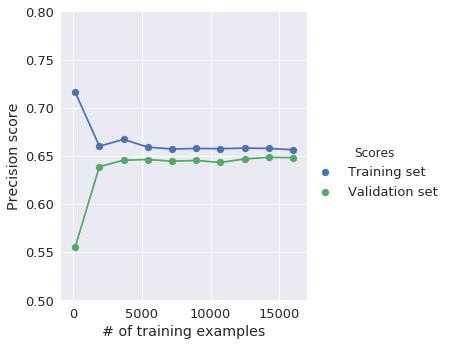

In [16]:
# Initialize a FacetGrid object using the table of scores and facet on
# the type of score
fig = sns.FacetGrid(
    make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5
)

# Plot the learning curves, add a legend, and rescale y-axis
fig.map(plt.scatter, '# of training examples', 'Precision score')
fig.map(plt.plot, '# of training examples', 'Precision score') \
    .add_legend() \
    .set(ylim=(0.5, 0.8));

The learning curves indicate the model is not suffering from high variance.

<a id="cell8"></a>
## 8. Using nested cross-validation to optimize hyperparameters

To optimize the regularization hyperparameter without optimistically biasing the model, let's incorporate nested cross-validation, which will also measure the robustness of the model.

In [17]:
# Select a range of values to test the regularization hyperparameter
param_grid = [{'C': np.logspace(-3, 3, 10)}]

# Inner cross-validation loop to tune the hyperparameter
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision',
    n_jobs=-1
)

# Outer cross-validation loop to assess model performance
scores = cross_val_score(
    estimator=grid_search,
    X=X_std,
    y=y_enc,
    cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=41),
    scoring='precision'
)

# Display cross-validation scores
scores

array([ 0.63995609,  0.63073852,  0.65509761,  0.68216216,  0.62788365,
        0.63354037,  0.6659436 ,  0.64968153,  0.63485477,  0.6521265 ])

The performance scores across the different cross-validation folds varies a bit&mdash;this is a sign that the model may be unstable. For now, let's compute the average precision score.

In [18]:
# Display the average precision score
scores.mean()

0.6471984815598224

<a id="cell9"></a>
## 9. Top predictors of funded projects

To determine the features that were most predictive of funded projects, let's first identify the optimal regularization hyperparameter.

In [19]:
# Identify the optimal regularization hyperparameter
grid_search.fit(X_std, y_enc)

# Display the hyperparameter value
grid_search.best_params_

{'C': 0.46415888336127775}

Let's use this hyperparameter value and train a final model on the entire training set to reduce pessimistic bias.

In [20]:
# Train the classifier on the entire dataset using the optimal hyperparameter
final_clf = LogisticRegression(C=0.46415888336127775)
final_clf.fit(X_std, y_enc);

Let's examine the features that were most predictive of funded projects.

In [21]:
# Add the corresponding feature names to the parameters
feature_ranks = pd.DataFrame(final_clf.coef_, index=['parameter value'])
feature_ranks.columns = X_cleaned.columns

# Display the weights of each feature
feature_ranks.sort_values('parameter value', axis=1, ascending=False).T

,parameter value
num_hyperlinks,0.295139
num_exclms,0.205970
num_words,0.198280
num_apple_words,0.180303
percent_bolded,0.119398
num_images,0.106464
num_youtubes,0.054815
num_all_caps,0.036212
percent_exclms,0.017294
num_gifs,0.013225


Surprisingly, the number of hyperlinks is the top predictor. Even more intriguing is that my hypothesis about having Apple adjectives was correct. Including these words helps a lot! The other top predictors are more or less expected such as having more bolded text, exclamation marks, and images&mdash;they all draw the reader's attention. 

One of the top predictors of *unfunded* projects was having higher average number of sentences per paragraph and words per sentence. This indicates being succinct is crucial to success!

<a id="cell10"></a>
## 10. Testing Kickstarter pages

For fun, let's use the feature extractor on a sample Kickstarter page, such as the [Pebble 2](https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra), and insert the processed features into the trained model to see how it fares with a highly successful project.

In [22]:
# Set the computed features and standardize them
computed_features = (
    182, 3549, 26, 0.007326007326007326, 12, 0.0033812341504649195, 
    6, 0.0016906170752324597, 19.5, 133, 1.5338345864661653, 
    21.511278195488721, 25, 0, 1, 0, 35, 57, 0.016060862214708368
)
scaled_features = scaler.transform([computed_features])

# Perform the prediction
final_clf.predict(scaled_features)

array([1])

We can even examine the probability of success.

In [23]:
# Display the probability of being funded with the given features
final_clf.predict_proba(scaled_features)[0, 1]

0.97648370783381577